### Info
The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables

## Notebook

In [1]:
import vaex
import numpy as np
import pandas as pd

In [2]:

# from datetime import datetime
# Code for initially converting to hdf5 format
# d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d')
# df= vaex.from_csv('train_data.csv', convert=True, chunk_size=100_000, parse_dates=['S_2'], 
#                   date_parser=d_parser)
df=vaex.open('train_data.csv.hdf5')

df.shape #No rows and features

(5531451, 190)

In [3]:
import pandas as pd
import seaborn as sns

In [4]:
# df.head(2)

In [5]:
print("There are {} unique customers in the dataset".format(df.customer_ID.nunique()))

There are 458913 unique customers in the dataset


In [6]:
df.rename('S_2','Date')

'Date'

In [7]:
cat_cols=['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [8]:
# for col in cat_cols:
#     print("\n {} \n".format(col),df[col].value_counts())

In [9]:
cat_use=['D_63']

#### One Hot Encoding

In [10]:
import vaex.ml
OneHotEncoder=vaex.ml.OneHotEncoder(features=cat_use,prefix='Encode_')
df=OneHotEncoder.fit_transform(df)

In [11]:
encoded_cols=[col for col in list(df.column_names) if col.startswith("Encode")]

#### Joining with target

In [12]:
# target= vaex.from_csv('train_labels.csv', convert=True)
target=vaex.open('train_labels.csv.hdf5')
df=df.join(target,on='customer_ID')

In [13]:
# df.target.value_counts()[1]/(df.target.value_counts()[0]+df.target.value_counts()[1])

In [14]:
# df.groupby([df.customer_ID]).agg({'Date':'count'})['Date'].value_counts()

#### Null values per variable

In [15]:
nulls={}
for col in df.column_names:
    nulls[col]=df[col].isna().sum().sum()

In [16]:
sort_list=sorted(nulls.items(), key=lambda x: x[1])

[('customer_ID', 0),
 ('Date', 0),
 ('D_39', 0),
 ('B_1', 0),
 ('R_1', 0),
 ('B_4', 0),
 ('B_5', 0),
 ('R_2', 0),
 ('D_47', 0),
 ('B_7', 0),
 ('D_51', 0),
 ('B_9', 0),
 ('R_3', 0),
 ('B_10', 0),
 ('S_5', 0),
 ('B_11', 0),
 ('S_6', 0),
 ('R_4', 0),
 ('B_12', 0),
 ('S_8', 0),
 ('R_5', 0),
 ('D_58', 0),
 ('B_14', 0),
 ('D_60', 0),
 ('S_11', 0),
 ('D_63', 0),
 ('D_65', 0),
 ('B_18', 0),
 ('S_12', 0),
 ('R_6', 0),
 ('S_13', 0),
 ('B_21', 0),
 ('D_71', 0),
 ('S_15', 0),
 ('B_23', 0),
 ('P_4', 0),
 ('D_75', 0),
 ('B_24', 0),
 ('R_8', 0),
 ('S_16', 0),
 ('R_10', 0),
 ('R_11', 0),
 ('S_17', 0),
 ('B_28', 0),
 ('R_13', 0),
 ('R_15', 0),
 ('R_16', 0),
 ('S_18', 0),
 ('D_86', 0),
 ('R_17', 0),
 ('R_18', 0),
 ('B_31', 0),
 ('S_19', 0),
 ('R_19', 0),
 ('B_32', 0),
 ('S_20', 0),
 ('R_21', 0),
 ('R_22', 0),
 ('R_23', 0),
 ('D_92', 0),
 ('D_93', 0),
 ('D_94', 0),
 ('R_24', 0),
 ('R_25', 0),
 ('D_96', 0),
 ('B_36', 0),
 ('D_127', 0),
 ('R_28', 0),
 ('Encode_D_63_CL', 0),
 ('Encode_D_63_CO', 0),
 ('Encod

#### List of cols to use

In [17]:
cols_use=[]
for col in df.column_names:
    if (nulls[col]==0 and col not in cat_cols) or (col in encoded_cols):
        cols_use.append(col)

In [18]:
new_cols=cols_use
new_cols.remove('customer_ID')
new_cols.remove('Date')
new_cols.remove('target')

#### Obtain the latest statement info for each customer

In [19]:
df_temp=df
# Code to get last value for each customer
new=df_temp.groupby([df.customer_ID],sort=True).agg({'Date':'max'})
df_temp=df_temp.join(new,on='customer_ID',rsuffix='_max')
df=df_temp[df_temp.Date == df_temp.Date_max].drop(['customer_ID_max','Date_max'])

In [20]:
# df.Date.min()

In [21]:
# df.Date.max()

In [22]:
# df=df[cols_use].groupby(df.customer_ID,agg='mean')
# df=df.drop('Date_mean',inplace=True)

#### Convert to pandas dataframe (vaex.ml wrapped tensorflow doesn't support GPU, pandas does)

In [23]:
df=df.to_pandas_df()

In [24]:
import pandas as pd
df.head(2)

,customer_ID,Date,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_143,D_144,D_145,Encode_D_63_CL,Encode_D_63_CO,Encode_D_63_CR,Encode_D_63_XL,Encode_D_63_XM,Encode_D_63_XZ,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,...,0.005810,0.002970,0.008533,0,0,1,0,0,0,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,...,0.003284,0.003169,0.008514,0,1,0,0,0,0,0


#### Split train and valid

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(df[new_cols],df.target,test_size=0.3,stratify=df.target)

#### Build and fit neural network

In [27]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [28]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True)

In [61]:
nn_model = keras.Sequential()
nn_model.add(layers.BatchNormalization(input_shape=[len(new_cols)]))
nn_model.add(layers.Dense(32, activation='relu'))
nn_model.add(layers.BatchNormalization()),
nn_model.add(layers.Dropout(rate=0.3)),
nn_model.add(layers.Dense(8, activation='relu'))
nn_model.add(layers.BatchNormalization()),
nn_model.add(layers.Dropout(rate=0.3)),
nn_model.add(layers.Dense(1,activation='sigmoid'))

nn_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['binary_accuracy'])

In [62]:
nn_model.fit(X_train,Y_train, validation_data=(X_valid,Y_valid), epochs=100,batch_size=10000,
             callbacks=[early_stopping])

Epoch 1/100
33/33 [==============================] - 1s 20ms/step - loss: 0.7419 - binary_accuracy: 0.5827 - val_loss: 0.5612 - val_binary_accuracy: 0.8262
Epoch 2/100
33/33 [==============================] - 0s 13ms/step - loss: 0.5332 - binary_accuracy: 0.7568 - val_loss: 0.4727 - val_binary_accuracy: 0.8580
Epoch 3/100
33/33 [==============================] - 0s 13ms/step - loss: 0.4674 - binary_accuracy: 0.7994 - val_loss: 0.4078 - val_binary_accuracy: 0.8662
Epoch 4/100
33/33 [==============================] - 0s 13ms/step - loss: 0.4257 - binary_accuracy: 0.8261 - val_loss: 0.3633 - val_binary_accuracy: 0.8699
Epoch 5/100
33/33 [==============================] - 0s 13ms/step - loss: 0.3950 - binary_accuracy: 0.8425 - val_loss: 0.3354 - val_binary_accuracy: 0.8720
Epoch 6/100
33/33 [==============================] - 0s 13ms/step - loss: 0.3715 - binary_accuracy: 0.8532 - val_loss: 0.3172 - val_binary_accuracy: 0.8742
Epoch 7/100
33/33 [==============================] - 0s 13ms/ste

#### Clear memory

In [30]:
import gc
del [[df,X_train,Y_train]]
gc.collect()
df=pd.DataFrame()
X_train=pd.DataFrame()
# X_valid=pd.DataFrame()
Y_train=pd.DataFrame()
# Y_valid=pd.DataFrame()

#### Load and preprocess test data

In [31]:
# from datetime import datetime
# d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d')
# test= vaex.from_csv('test_data.csv', convert=True, chunk_size=100_000, parse_dates=['S_2'], 
#                   date_parser=d_parser)
test=vaex.open('test_data.csv.hdf5')

In [32]:
test.rename('S_2','Date')

'Date'

In [33]:
test=OneHotEncoder.fit_transform(test)

In [34]:
test.head(2)

#,customer_ID,Date,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,Encode_D_63_CL,Encode_D_63_CO,Encode_D_63_CR,Encode_D_63_XL,Encode_D_63_XM,Encode_D_63_XZ
0,'00000469ba478561f23a92a868bd366de6f6527a684c9a2...,2019-02-19 00:00:00.000000000,0.631315,0.00191178,0.0107281,0.814497,0.0075469,0.168651,0.00997145,0.00234699,0.113189,nan,0.00758394,0.116402,0.00448252,0.00951677,0.00517788,nan,0.474383,0.626467,nan,0.174591,1.25068,1.00393,nan,0.00871788,0.00101294,0.10359,0.119043,nan,-0.00291864,nan,0.00277111,0.00441611,1.00687,1.00507,0.00280969,0.105587,0.119198,0.321676,0.114564,nan,nan,0.00341963,0.205898,nan,0.0101822,nan,0.0274716,0.588734,0.0104886,1.88186,0.051811,CR,--,0.0082942,0.00866339,nan,0.592103,0.00914422,nan,0.00498556,nan,0.190516,0.00267548,0.409411,0.00999046,nan,0.00521039,nan,0.0146841,0.00431024,0.400602,1.13479,0.178862,0.959531,0.217694,0.20459,nan,0.00979851,0.00774832,0.00291611,0.00689558,0.00165645,0.00435566,nan,0.00200825,nan,0.00253103,0.000347592,0.00117267,0.00417011,0.00458466,0.0022906,0.50824,0.00509321,1.00294,0.133804,0.00432192,nan,0.00885726,0.00414409,0.00956315,0.00694241,nan,0,0.00368354,0.00990896,nan,0.00890767,0.00295539,nan,1,0.00899935,0.0034176,0.00220038,0.00378094,0.00294782,0.00463466,1.00381,0.00665331,0.00747407,0.000191559,nan,0.00876118,0.000834586,0.00438883,0.00411474,0.008442,0.00957461,0.981078,0.134916,0.954664,0.971086,0.00656218,0.00241861,nan,nan,nan,nan,nan,0.00814552,0.00796956,nan,nan,1,nan,0.00512378,nan,nan,nan,1.00413,0.274203,0.00430155,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0.00620146,nan,nan,0.00966439,nan,nan,nan,nan,0.00708155,0.00595746,nan,nan,nan,nan,nan,nan,0.00466874,nan,nan,nan,0.00828072,nan,0,0,1,0,0,0
1,'00000469ba478561f23a92a868bd366de6f6527a684c9a2...,2019-03-25 00:00:00.000000000,0.587042,0.00527516,0.0110264,0.810848,0.00181713,0.241389,0.000165841,0.00913184,0.123035,nan,0.00664612,0.134878,0.00949742,0.0263128,0.00902887,nan,0.473587,0.611682,nan,0.177115,0.234169,1.0093,nan,0.00314562,0.00553325,0.101239,0.120991,nan,0.0312215,nan,0.00649655,0.010003,1.00573,1.00043,0.000525444,0.160562,0.12149,0.170728,0.184116,nan,0.028347,0.00715627,0.40327,0.0144908,0.0251299,nan,0.0547896,0.622886,0.0217041,2.04328,0.0575675,CR,--,0.00201132,0.000834965,nan,0.590922,0.000164971,nan,0.00155656,nan,0.190172,0.001771,0.561424,0.00812512,nan,0.0083936,0.000605985,0.0119452,0.00228308,0.605887,0.208381,0.179502,0.961667,0.216526,0.20657,nan,0.00454856,0.00309792,nan,0.00368181,0.00551609,0.00150627,0.00101343,0.00644376,nan,0.00716918,0.003077,0.00588013,0.00405636,0.00963441,0.00122534,0.508681,0.00731878,1.00383,0.144626,0.00530049,nan,0.00147682,0.00208327,0.00223393,0.0055229,nan,0,0.00640957,0.00745846,nan,0.000842595,0.00745731,nan,1,0.00512042,0.00238172,0.00655687,0.00169092,0.00444885,0.000574375,1.00463,0.00439397,0.00116868,0.00669346,nan,0.00431823,0.00807239,0.00788821,0.0076558,0.0063469,0.00695177,0.966995,0.138531,0.957019,0.975003,0.00461062,0.00654858,0.00303095,0.00875541,nan,nan,0.00469763,7.76608e-05,0.0154626,nan,1.00767,1,nan

In [35]:
# test.Date.min()

In [36]:
# test.Date.max()

In [37]:
# print("There are {} unique customers in the dataset\n".format(test.customer_ID.nunique()))
# test.groupby([test.customer_ID]).agg({'Date':'count'})['Date'].value_counts()

In [38]:
# test_cols=list(test.columns)
# test_nulls={}
# for col in test_cols:
#     test_nulls[col]=test[col].isna().sum().sum()

In [39]:
# null_df=pd.DataFrame({'Train':nulls,'Test':test_nulls})

In [40]:
# pd.set_option('display.max_rows', None)
# null_df.head(200)

In [41]:
# test=test[cols_use].groupby(test.customer_ID,agg='mean')
new_test=test.groupby([test.customer_ID],sort=True).agg({'Date':'max'})
test=test.join(new_test,on='customer_ID',rsuffix='_max')
test=test[test.Date == test.Date_max].drop(['customer_ID_max','Date_max'])

test=test.to_pandas_df()
# test=test.drop('Date_mean',inplace=True)

In [42]:
# test.head(2)

#### Make predictions

In [43]:
prediction=nn_model.predict(test[new_cols])

In [44]:
test['prediction']=prediction
final=test[['customer_ID','prediction']]

In [45]:
import numpy as np
import seaborn as sns

#### Visualize predictions

<AxesSubplot:>

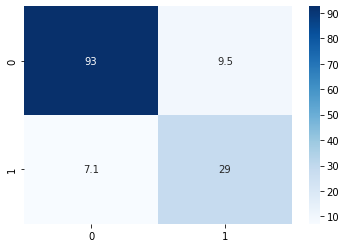

In [63]:
#Move up, then delete valids for memory
from sklearn.metrics import confusion_matrix
Y_valid_pred=pd.DataFrame(index=np.arange(0,len(Y_valid)))
Y_valid_pred['prediction']=nn_model.predict(X_valid[new_cols])
Y_valid_pred['prediction']=Y_valid_pred.prediction.apply(lambda x: 1 if x>=0.5 else 0)
cf_matrix = confusion_matrix(Y_valid, Y_valid_pred.prediction)
sns.heatmap(cf_matrix/1000, annot=True,cmap='Blues')

Custom metric provided by the competition hosts is copy pasted below

In [56]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    def top_four_percent_captured(y_true=y_true, y_pred=y_pred) -> float:
        y_pred=y_pred.set_index(y_true.index)
        df = pd.concat([y_true, y_pred], axis=1,join='inner')
        df=df.sort_values(by=['prediction'], ascending=False,axis=0)
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true=y_true, y_pred=y_pred) -> float:
        y_pred=y_pred.set_index(y_true.index)
        df = pd.concat([y_true, y_pred], axis=1,join='inner')
        df=df.sort_values(by=['prediction'], ascending=False)
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true=y_true, y_pred=y_pred) -> float:
        y_pred=y_pred.set_index(y_true.index)
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [64]:
Y_valid=pd.DataFrame(Y_valid)
amex_metric(Y_valid,Y_valid_pred)

0.5064450886274932

In [47]:
final

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.027653
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.022012
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.100707
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.280830
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.867141
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.027834
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.639607
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.156907
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.305726


In [48]:
final['prediction']=final['prediction'].apply(lambda x: 1 if x>=0.5 else 0)

C:\Users\julia\AppData\Local\Temp\ipykernel_12492\939794576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['prediction']=final['prediction'].apply(lambda x: 1 if x>=0.5 else 0)


In [49]:
final['prediction'].value_counts()

0    730395
1    194226
Name: prediction, dtype: int64

In [85]:
# val['keras_pred'].value_counts()

0    711968
1    212653
Name: keras_pred, dtype: int64

In [50]:
final.to_csv('submission.csv',index=False)